In [38]:
import keras 
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


In [39]:
data_train = pd.read_csv('train.txt',sep=";")
data_test = pd.read_csv("test.txt",sep=";")
data_val = pd.read_csv("val.txt",sep=";")

In [40]:
data_train.rename(columns = {'i didnt feel humiliated':"Statements",'sadness':"Emotions"},inplace = True)
data_test.rename(columns = {'im feeling rather rotten so im not very ambitious right now':'Statements','sadness':'Emotions'},inplace = True)
data_val.rename(columns = {'im feeling quite sad and sorry for myself but ill snap out of it soon':"Statements",'sadness':"Emotions"},inplace = True)

In [41]:
data_test.head(10)

,Statements,Emotions
0,im updating my blog because i feel shitty,sadness
1,i never make her separate from me because i do...,sadness
2,i left with my bouquet of red and yellow tulip...,joy
3,i was feeling a little vain when i did this one,sadness
4,i cant walk into a shop anywhere where i do no...,fear
5,i felt anger when at the end of a telephone call,anger
6,i explain why i clung to a relationship with a...,joy
7,i like to have the same breathless feeling as ...,joy
8,i jest i feel grumpy tired and pre menstrual w...,anger
9,i don t feel particularly agitated,fear


In [42]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

In [47]:
def cleaning_statements(df):
    clean_sentence = []
    lemma = WordNetLemmatizer()
    
    for sent in tqdm(df['Statements']):
        sent = sent.lower()
        clean_sent = sent.translate(str.maketrans("","",string.punctuation))
        words = word_tokenize(clean_sent)
        clean_words = [i for i in words if i not in stopwords.words('english')]
        lemma_words = [lemma.lemmatize(i) for i in clean_words]
        
        clean_sentence.append(lemma_words)
        
    return clean_sentence     
        

In [48]:
train_sent = cleaning_statements(data_train)
test_sent = cleaning_statements(data_test)

100%|█████████████████████████████████████████████████████████████████████████████| 1999/1999 [00:07<00:00, 281.07it/s]


In [54]:
from sklearn.preprocessing import LabelEncoder

In [56]:
le = LabelEncoder()
data_train["Emotions"] = le.fit_transform(data_train["Emotions"])
data_test["Emotions"] = le.transform(data_test["Emotions"])
data_val["Emotions"] = le.transform(data_val["Emotions"])

In [57]:
from keras.utils import to_categorical

In [60]:
y = data_train.Emotions.values
y = to_categorical(y)
num_classes = y.shape[1]

In [61]:
from sklearn.model_selection import train_test_split

In [79]:
x_train,x_test,y_train,y_test = train_test_split(train_sent,y,test_size=0.2,random_state =10,stratify=y)

In [80]:
unique_words = set()
len_max = 0

for sent in tqdm(x_train):
    unique_words.update(sent)
    
    if len_max < len(sent):
        len_max = len(sent)
        

print(len(list(unique_words)))
print(len_max)

100%|████████████████████████████████████████████████████████████████████████| 12799/12799 [00:00<00:00, 246797.49it/s]

11989
35


In [81]:
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

In [83]:
tokenizer = Tokenizer(num_words = len(list(unique_words)))
tokenizer.fit_on_texts(list(x_train))

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
x_val = tokenizer.texts_to_sequences(test_sent)

x_train = sequence.pad_sequences(x_train,maxlen=len_max)
x_test = sequence.pad_sequences(x_test,maxlen=len_max)
x_val = sequence.pad_sequences(x_val,maxlen=len_max)

In [84]:
from keras.models import Sequential
from keras.layers import Dense,LSTM,Embedding,Dropout

In [100]:
model = Sequential()

model.add(Embedding(len(list(unique_words)),180,input_length=len_max))
#model.add(LSTM(256,dropout=0.5,recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(128,dropout=0.5,recurrent_dropout=0.5,return_sequences=True))
#model.add(LSTM(64,dropout=0.5,recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(32,dropout=0.5,recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(128,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer="Adam",metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 35, 180)           2158020   
_________________________________________________________________
lstm_23 (LSTM)               (None, 35, 128)           158208    
_________________________________________________________________
lstm_24 (LSTM)               (None, 32)                20608     
_________________________________________________________________
dense_12 (Dense)             (None, 128)               4224      
_________________________________________________________________
dense_13 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 6)                

In [101]:
history = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=15,batch_size=128)

C:\Users\danis\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 12799 samples, validate on 3200 samples
Epoch 1/15
12799/12799 [==============================] - 31s 2ms/step - loss: 1.6508 - accuracy: 0.3112 - val_loss: 1.5765 - val_accuracy: 0.3353
Epoch 2/15
12799/12799 [==============================] - 29s 2ms/step - loss: 1.5431 - accuracy: 0.3275 - val_loss: 1.3118 - val_accuracy: 0.3984
Epoch 3/15
12799/12799 [==============================] - 20s 2ms/step - loss: 1.1002 - accuracy: 0.5225 - val_loss: 0.8212 - val_accuracy: 0.6822
Epoch 4/15
12799/12799 [==============================] - 13s 989us/step - loss: 0.7367 - accuracy: 0.7115 - val_loss: 0.7299 - val_accuracy: 0.7250
Epoch 5/15
12799/12799 [==============================] - 15s 1ms/step - loss: 0.5902 - accuracy: 0.7550 - val_loss: 0.6553 - val_accuracy: 0.7600
Epoch 6/15
12799/12799 [==============================] - 13s 1ms/step - loss: 0.4977 - accuracy: 0.7847 - val_loss: 0.6379 - val_accuracy: 0.7541
Epoch 7/15
12799/12799 [==============================] - 12s 908us

## Accuracy and Loss Visualisation :

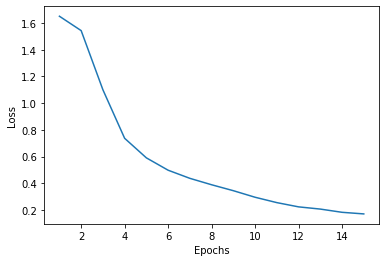

In [103]:
epoch_count = range(1,len(history.history["loss"])+1)

plt.plot(epoch_count,history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

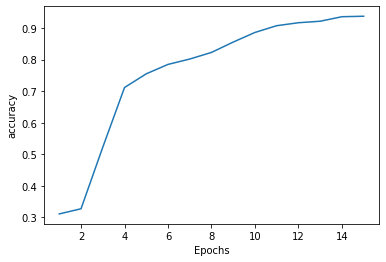

In [105]:
plt.plot(epoch_count,history.history["accuracy"])
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.show()

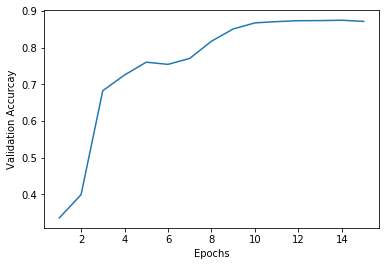

In [106]:
plt.plot(epoch_count,history.history["val_accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Validation Accurcay")
plt.show()

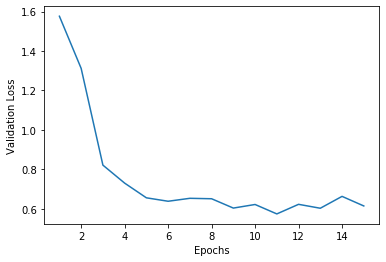

In [107]:
plt.plot(epoch_count,history.history["val_loss"])
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.show()

In [108]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [109]:
y_pred = model.predict_classes(x_val)

In [111]:
classification_report(data_val['Emotions'],y_pred)

'              precision    recall  f1-score   support\n\n           0       0.12      0.12      0.12       275\n           1       0.12      0.12      0.12       212\n           2       0.37      0.35      0.36       704\n           3       0.06      0.07      0.06       178\n           4       0.30      0.31      0.30       549\n           5       0.03      0.02      0.03        81\n\n    accuracy                           0.25      1999\n   macro avg       0.17      0.17      0.17      1999\nweighted avg       0.25      0.25      0.25      1999\n'

## Predictions :

### 1

In [115]:
predictions = pd.read_csv("predictions.txt")

In [116]:
predictions.head()

,Statements
0,i walked out of there an hour and fifteen minu...
1,i feel try to tell me im ungrateful tell me im...
2,i feel like im caring about my body not in jus...
3,i know it so difficult especially when you fee...
4,i see the starlight caress your hair no more f...


In [121]:
pred_sent = cleaning_statements(predictions)
pred_sent = tokenizer.texts_to_sequences(pred_sent)
pred_sent = sequence.pad_sequences(pred_sent,maxlen=len_max)

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 200.53it/s]


In [122]:
y_prediction = model.predict_classes(pred_sent)

In [131]:
print(le.inverse_transform(y_prediction))

['sadness' 'sadness' 'love' 'anger' 'love']


### 2

In [136]:
predictions2 = pd.read_csv('predictions2.txt',sep=';')

In [137]:
predictions2.head()

,Statements
0,I think i am going to be very successful very ...
1,i feel like empty inside... nothing has any me...
2,"i cannot belive that it has come to this , thi..."
3,"Your hair like a winter fire, january embers, ..."
4,this is such a great news for everone involved...


In [140]:
pred2_sent = cleaning_statements(predictions2)
pred2_sent = tokenizer.texts_to_sequences(pred2_sent)
pred2_sent = sequence.pad_sequences(pred2_sent,maxlen=len_max)

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 385.63it/s]


In [142]:
y_predictions2 = model.predict_classes(pred2_sent)
print(le.inverse_transform(y_predictions2))

['joy' 'sadness' 'anger' 'joy' 'sadness']
